<h3> Embeddingi

In [1]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

ImportError: cannot import name 'ParamSpec' from 'typing_extensions' (C:\Users\48795\anaconda3\lib\site-packages\typing_extensions.py)

In [3]:
from sklearn.decomposition import PCA

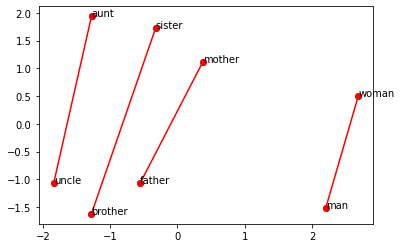

In [4]:
X = []
words = ['woman', 'man', 'sister','brother', 'uncle', 'aunt', 'mother', 'father'] #wybieram grupe slow
for word in words:
    X.append(glove[word].tolist()) #patrze jakie mają embeddingi
    
X = np.array(X) #tworze z nich macierz

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)  #redukuje liczbe zmiennych z 50 do 2 dla kazdego slowa


#Do rysowania: 

x = X_pca[:,0] #pierwsza zmienna
y = X_pca[:,1] #druga zmienna


plt.scatter(x,y)

for i, txt in enumerate(words):
    plt.annotate(txt, (x[i], y[i]))
    
for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    
plt.show()

<h4> Zadanie1: Zaznacz na płaszczyźnie (i połącz linią) następujące nazwy państw/stolic: 'france', 'paris', 'poland', 'warsaw', 'germany', 'berlin', 'netherlands', 'amsterdam'. Do redukcji ilości zmiennych wykorzystaj PCA. Skomentuj wyniki.

<h4> Zadanie2: Zaznacz na płaszczyźnie (nie łącz) następujące słowa: 'dog', 'cat', 'cow', 'horse', 'sheep', 'sunflower', 'carrot', 'salad', 'potato','cucumber'. Czy obserwujesz jakąś zależność?

<h3> Ku rekurencyjnym sieciom neurnowym...

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize

In [2]:
def data():
    return csv.reader(open("training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1")) #laduje dane [tweety]

In [5]:
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) #50 wymiarowe wekotry, uzywamy 10 tys najczęstszych slow

100%|█████████████████████████████████████████████████████████████████████████▉| 9999/10000 [00:00<00:00, 21992.73it/s]


In [6]:
print(dir(glove))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'cache', 'dim', 'get_vecs_by_tokens', 'itos', 'stoi', 'unk_init', 'url', 'vectors']


In [11]:
#wyswietlam pierwsze 4 tweety

for i, line in enumerate(data()): 
    if i > 3:
        break
    print(word_tokenize(line[-1].lower()))


['@', 'switchfoot', 'http', ':', '//twitpic.com/2y1zl', '-', 'awww', ',', 'that', "'s", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']
['is', 'upset', 'that', 'he', 'ca', "n't", 'update', 'his', 'facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', '.', 'blah', '!']
['@', 'kenichan', 'i', 'dived', 'many', 'times', 'for', 'the', 'ball', '.', 'managed', 'to', 'save', '50', '%', 'the', 'rest', 'go', 'out', 'of', 'bounds']
['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire']


In [21]:
#ktore slowa z czwartego tweeta mają embeddingi?
print([w for w in ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'] if w in glove.stoi])

['my', 'whole', 'body', 'feels', 'and', 'like', 'its', 'on', 'fire']


In [22]:
#indeksy tych embeddingow
print([glove.stoi[w] for w in ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'] if w in glove.stoi])

[192, 1115, 719, 3866, 5, 117, 47, 13, 484]


In [26]:
glove["fire"] #embedding dla "fire"

tensor([ 0.5091, -0.3681,  0.4128, -0.4464, -0.0179, -0.1243, -0.4375,  0.5202,
        -0.1449, -0.8396, -0.3224, -0.7114, -0.4387, -0.1318, -0.2773,  0.0112,
         0.0976,  0.5546, -1.3955, -0.5844,  0.2527,  0.7464, -0.1807, -0.4655,
        -0.0936, -1.4951,  0.2663,  0.5531,  1.1030, -0.0600,  3.0834, -0.5712,
        -0.9129, -0.5201,  0.0579,  0.8553,  0.7537, -1.2263,  0.6060,  0.7614,
        -0.0281, -0.0778, -0.1043, -0.5089,  0.9201,  0.2151, -0.2919, -0.0336,
         0.0560, -0.4328])

In [27]:
#funkcja ktora dla danych zwraca trzy listy reprezentujące zbior testowy, walidacyjny i do trenowania, kazdy element to krotka: ([indeksy_embeddingow], label)

def get_tweet_words(glove_vector, data): #argumenty: glove_vector - info o embeddingach, data = dane
    train, valid, test = [], [], []  #puste listy na dane treningowe, walidacyjne, do testowania
    for i, line in enumerate(data):
        if i % 29 == 0:             #wybieram co 29 rekord (zeby w miare szybko sie nauczyl model; normalnie by mozna pominąc tego ifa)
            tweet = line[-1]        #kolejny tweet
            idx = [glove_vector.stoi[w] for w in word_tokenize(tweet.lower()) if w in glove_vector.stoi] #zapisuje indeksy slow ktore mialy embeddingi
            if not idx: #jezeli zdarzy sie jakis tweet ktory nie ma zadnego embeddingu to pobiera kolejny rekord (nie robi tego co dalej)
                continue
            idx = torch.tensor(idx) #zapisuje indeksy jakot tensor
            label = torch.tensor(int(line[0] == "4")).long() #label dla tweeta, 0 gdy bylo 0, 1 gdy  bylo 4 (wartosc logiczną tranformuje w liczbe calkowitą a następnie zapisuje do tensora)
            #chce sobie podzielic dane na trzy kategorie: zbior treningowy, walidacyjny i testowy [3 na 5 będe zapisywal do testowego, 1 na 5 do walidacyjnego, 1 na 5 do testowego]
            if i % 5 < 3:  #czyli 0,1,2 [60% danych]
                train.append((idx, label))
            elif i % 5 == 3: #20 % danych
                valid.append((idx, label))
            else:            # pozostale 20% danych
                test.append((idx, label))
    return train, valid, test #zwraca zbior treningowy, walidacyjny i testowy

In [28]:
train, valid, test = get_tweet_words(glove, data()) #generuje te trzy listy

In [29]:
print(train[0])

(tensor([  45,   11,    1,   12,    9,    7,    2,   81,  405,  684, 9912,    3,
         245,  122,    4,   88,   20,    2,   89, 1968]), tensor(0))


In [30]:
tweet0, label0 = train[0]

In [31]:
print(tweet0)
print(label0)

tensor([  45,   11,    1,   12,    9,    7,    2,   81,  405,  684, 9912,    3,
         245,  122,    4,   88,   20,    2,   89, 1968])
tensor(0)


In [32]:
len(tweet0) #ile tam bylo slow z embeddingami

20

In [33]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors) #zeby uzyc potem gotowych embeddingow
tweet_emb = glove_emb(tweet0)  #tworzy mi tensor z embeddingami dla kazdego slowa z tweet0

In [34]:
tweet_emb.shape #wymiar

torch.Size([20, 50])

In [35]:
print(tweet_emb)

tensor([[-1.7587e-01,  1.3508e+00, -1.8159e-01,  4.5197e-01,  3.7554e-01,
         -2.0926e-01,  1.4956e-02, -8.7286e-01, -5.4443e-01, -2.5731e-01,
         -5.2100e-01,  6.2242e-01, -5.2387e-01, -6.1782e-02,  1.1805e+00,
         -4.1984e-02,  1.0582e-01, -2.0913e-01, -5.4508e-01,  2.7728e-02,
         -3.1329e-01,  1.3439e-01,  5.5192e-01,  7.5419e-01,  3.0996e-01,
         -1.3301e+00, -9.8620e-01, -3.3747e-01,  1.7633e-01, -3.7547e-01,
          3.4474e+00,  1.4171e-01, -6.5033e-01,  1.0118e-01,  1.4796e-04,
         -7.4707e-02,  1.9146e-01, -4.7977e-01,  3.9628e-01, -1.3403e-01,
          4.3043e-01,  4.5704e-01,  5.9387e-01, -4.0308e-01,  6.7302e-02,
          1.2784e+00,  4.9927e-01,  1.5617e-01,  5.6650e-01,  6.1385e-01],
        [-1.6768e-01,  1.2151e+00,  4.9515e-01,  2.6836e-01, -4.5850e-01,
         -2.3311e-01, -5.2822e-01, -1.3557e+00,  1.6098e-01,  3.7691e-01,
         -9.2702e-01, -4.3904e-01, -1.0634e+00,  1.0280e+00,  5.3943e-03,
          4.1530e-02, -1.8638e-02, -5

In [36]:
tweet_input = tweet_emb.unsqueeze(0) #dodaje dodatkowy wymiar (bo taki będzie oczekiwany pozniej)

print(tweet_input)

tensor([[[-1.7587e-01,  1.3508e+00, -1.8159e-01,  4.5197e-01,  3.7554e-01,
          -2.0926e-01,  1.4956e-02, -8.7286e-01, -5.4443e-01, -2.5731e-01,
          -5.2100e-01,  6.2242e-01, -5.2387e-01, -6.1782e-02,  1.1805e+00,
          -4.1984e-02,  1.0582e-01, -2.0913e-01, -5.4508e-01,  2.7728e-02,
          -3.1329e-01,  1.3439e-01,  5.5192e-01,  7.5419e-01,  3.0996e-01,
          -1.3301e+00, -9.8620e-01, -3.3747e-01,  1.7633e-01, -3.7547e-01,
           3.4474e+00,  1.4171e-01, -6.5033e-01,  1.0118e-01,  1.4796e-04,
          -7.4707e-02,  1.9146e-01, -4.7977e-01,  3.9628e-01, -1.3403e-01,
           4.3043e-01,  4.5704e-01,  5.9387e-01, -4.0308e-01,  6.7302e-02,
           1.2784e+00,  4.9927e-01,  1.5617e-01,  5.6650e-01,  6.1385e-01],
         [-1.6768e-01,  1.2151e+00,  4.9515e-01,  2.6836e-01, -4.5850e-01,
          -2.3311e-01, -5.2822e-01, -1.3557e+00,  1.6098e-01,  3.7691e-01,
          -9.2702e-01, -4.3904e-01, -1.0634e+00,  1.0280e+00,  5.3943e-03,
           4.1530e-02, -

In [37]:
#Zauważmy, że kolejne tweety z train zawierają rozne ilosci embeddingow --> to problem
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([20])
torch.Size([29])
torch.Size([8])
torch.Size([25])
torch.Size([6])
torch.Size([5])
torch.Size([11])
torch.Size([8])
torch.Size([7])
torch.Size([33])


<h3> RNN

In [38]:
rnn_layer = nn.RNN(input_size=50,    #wymiar cech wejscia (wymiar embeddinga)
                   hidden_size=5,   #wymiar cech w stanie ukrytym
                   batch_first=True) 

In [39]:
list(rnn_layer.parameters()) #losowe parametry na początek

[Parameter containing:
 tensor([[-1.9780e-01, -3.7430e-01, -1.2457e-01, -2.6392e-01, -1.6460e-02,
          -5.7580e-02, -2.4900e-01,  2.6096e-01, -1.6259e-01,  2.2439e-01,
          -3.4196e-01,  1.6028e-01, -1.3927e-01, -3.9046e-01, -4.0019e-01,
          -4.3444e-01,  4.4608e-01, -3.1892e-01,  6.8150e-02, -1.8801e-01,
           8.3608e-02, -6.9456e-02,  1.7953e-01, -2.7886e-01, -9.8469e-02,
           3.9215e-01,  2.6074e-01, -1.3219e-01, -3.5480e-01, -2.4380e-01,
           4.2606e-01, -3.1004e-01,  2.0901e-01, -3.2756e-01, -1.6422e-01,
          -2.3101e-01,  4.5475e-02,  3.4477e-01, -3.9251e-01,  1.1577e-01,
           1.0649e-01, -4.1822e-01,  2.6021e-01,  2.5132e-01,  2.1316e-01,
          -2.9727e-01,  1.8127e-01,  5.9348e-02,  7.9824e-02,  3.8684e-02],
         [-2.2817e-01, -4.3777e-01, -3.4202e-01,  3.9784e-01, -1.1588e-01,
          -3.2972e-01,  2.5894e-01,  2.8677e-01,  3.2078e-01, -4.0974e-01,
           2.6984e-01,  1.2771e-01,  1.2110e-02, -3.6522e-02, -7.4364e-02,
 

In [40]:
h0 = torch.zeros(1, 1, 5)     #początkowy stan ukryty
print(h0)

tensor([[[0., 0., 0., 0., 0.]]])


In [41]:
out, last_hidden = rnn_layer(tweet_input, h0) #przejscie po modelu na podstawie danych z pierwszego tweeta i h0

In [42]:
print(out)

tensor([[[-0.6749,  0.5155, -0.1366,  0.6992,  0.3812],
         [-0.6186, -0.4248, -0.7309,  0.9748, -0.9907],
         [ 0.7518, -0.3040, -0.9510,  0.7014, -0.5050],
         [ 0.7188, -0.4968, -0.9779,  0.7941, -0.6272],
         [-0.4254, -0.4404, -0.9338,  0.5421, -0.7845],
         [ 0.2815, -0.7929, -0.9895,  0.9278, -0.7487],
         [ 0.6580,  0.0107, -0.8969,  0.4199, -0.3643],
         [ 0.0441, -0.6824, -0.9790,  0.5948, -0.5952],
         [ 0.8039, -0.8730, -0.8384,  0.3765, -0.1990],
         [ 0.9746,  0.4345, -0.9054, -0.6581, -0.2703],
         [ 0.9275,  0.2424, -0.6019, -0.8565,  0.3677],
         [ 0.3888,  0.0540, -0.9756,  0.9669, -0.7291],
         [ 0.9032, -0.0768, -0.0732,  0.0014, -0.2195],
         [-0.2553, -0.6365, -0.0561,  0.2538, -0.8604],
         [ 0.7132, -0.8273, -0.6436,  0.5616, -0.6155],
         [ 0.7045, -0.2744, -0.8903,  0.4737, -0.3658],
         [ 0.6887, -0.1745, -0.9887,  0.7090,  0.0205],
         [ 0.7042,  0.1592, -0.9476,  0.4686, -0

In [43]:
out[:,-1,:] #ostatni output

tensor([[ 0.8379,  0.9175, -0.9767, -0.9374,  0.7083]],
       grad_fn=<SliceBackward0>)

In [47]:
last_hidden #tak jak wyzej

tensor([[[ 0.8379,  0.9175, -0.9767, -0.9374,  0.7083]]],
       grad_fn=<StackBackward0>)

In [45]:
out2, last_hidden2 = rnn_layer(tweet_input) #jak nie podamy drugiego argumentu (h0) to domyślnie wezmie tensor zerowy

In [46]:
last_hidden2

tensor([[[ 0.8379,  0.9175, -0.9767, -0.9374,  0.7083]]],
       grad_fn=<StackBackward0>)

In [48]:
#Model RNN do wiadomosci tweet

class T_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): #parametry: input_size = wymiar Embeddingu, hidden_size - zadajemy, num_classes = ile kategorii
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors) #embeddingi
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) #RNN
        self.fc = nn.Linear(hidden_size, num_classes)  #przeksztalcenie liniowe
    
    def forward(self, x):
        x = self.emb(x) #wyznacza embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy stan ukryty
        out, _ = self.rnn(x, h0)  #RNN
        out = self.fc(out[:, -1, :]) #przez funkcje liniową przekształcamy ostatni output
        return out

In [49]:
model = T_RNN(50, 6, 2) #buduje model z konkretnymi parametrami

<h4> Problem z batchingiem


In [50]:
from torch.nn.utils.rnn import pad_sequence

#przykladowe rozwiązanie jak zrobic zeby tensory dla kolejnych tweetow mialy tę samą dlugosc
tweet_padded = pad_sequence([tweet for tweet, label in train[:10]], batch_first=True) #dodawanie zer do pierwszych 10 tweetow

In [51]:
tweet_padded.shape

torch.Size([10, 33])

In [52]:
print(tweet_padded)

tensor([[  45,   11,    1,   12,    9,    7,    2,   81,  405,  684, 9912,    3,
          245,  122,    4,   88,   20,    2,   89, 1968,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 192,    2,   41, 4284,   83,    0,   31, 1096,    4,   88,   17,   20,
          188,   83,  100,    1,   20,    9,  500,    1,   41,  169,   20,    1,
          837, 4375,  805,  805,  805,    0,    0,    0,    0],
        [8738,   34,   41,  346,   41, 1346,    7, 1019,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  41,  149,   33,   70, 1465,    0, 7035, 1161, 8457,   89, 3630, 4242,
         4798,  116,  285, 7033,   22,    0,  156,    2,  155,   32, 1673, 1145,
            2,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 414,   30,  881,    7, 9085,  378,    0,    0,    0,    0,    0,    0,
            0, 

In [53]:
#teraz mozna je wrzucic do modelu
out = model(tweet_padded)
out.shape

torch.Size([10, 2])

In [54]:
out

tensor([[-0.1697,  0.3681],
        [-0.1745,  0.3668],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1697,  0.3681],
        [-0.1075,  0.1989]], grad_fn=<AddmmBackward0>)

In [55]:
#Nieco lepsze rozwiązanie

import random

class TBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        self.tweets_by_length = {} #slownik, przechowuje klucze - dlugosci i wartosci - liste tweetow o zadanej dlugosci
        for words, label in tweets:
            wlen = words.shape[0] #liczy dlugosc tweeta (ile ma embeddingow)
            
            if wlen not in self.tweets_by_length: #jak jeszcze nie pojawil sie tweet o takiej dlugosci
                self.tweets_by_length[wlen] = []  #to stworz go i przypisz mu pustą liste
                
            self.tweets_by_length[wlen].append((words, label),) #dodaje do listy krotke slowa, label
         
        #tworze DataLoader dla kazdego zbioru tweetow o tej samej dlugosci
        self.loaders = {wlen : torch.utils.data.DataLoader(tweets, batch_size=batch_size, shuffle=True, drop_last=drop_last) for wlen, tweets in self.tweets_by_length.items()}
    
    #Iterator, to nie takie wazne...
    def __iter__(self): 
        iters = [iter(loader) for loader in self.loaders.values()] #tworze iterator dla kazdej dlugosci tweetow
        while iters:
            im = random.choice(iters) #generuje losowy iterator
            try:
                yield next(im)      #yield uzywamy kiedy iterujemy po sekwencji ale nie chcemy przechowywac calej sekwencji w pamieci (cos jak return)
            except StopIteration:
                iters.remove(im)

In [56]:
train_TB = TBatcher(train, drop_last=True) #wywoluje te funkcje na train


for i, (tweets, labels) in enumerate(train_TB):
    if i > 5: 
        break
    print(tweets.shape, labels.shape) #32 tweety o okreslonej liczbie embeddingow

torch.Size([32, 33]) torch.Size([32])
torch.Size([32, 26]) torch.Size([32])
torch.Size([32, 34]) torch.Size([32])
torch.Size([32, 3]) torch.Size([32])
torch.Size([32, 18]) torch.Size([32])
torch.Size([32, 22]) torch.Size([32])


In [57]:
#Funkcja wyznaczająca dokładność predykcji:

def get_accuracy(model, data_loader):
    correct, total = 0, 0  #ile ok, ile wszystkich
    for tweets, labels in data_loader: #przechodzi dane
        output = model(tweets) #co mowi model
        pred = output.max(1, keepdim=True)[1]  #ktora kategoria
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [58]:
test_loader = TBatcher(test, batch_size=64, drop_last=False)
get_accuracy(model, test_loader)

0.4888584474885845

In [59]:
#funkcja do treningu

def RNN_train(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss() #funkcja kosztu
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #optymalizator modelu
    losses, train_acc, valid_acc, epochs = [], [], [], []  #cztery listy na wartosci funkcji kosztu, dokladnosc na zbiorze testowym i walidacyjnym, numer epoki
    
    for epoch in range(num_epochs): #przechodz kolejne epoki (iteracje)
        for tweets, labels in train: #przechodzi dane ze zbioru testowego
            optimizer.zero_grad()   #zerowanie gradientu
            pred = model(tweets)    #co mowi model?
            loss = criterion(pred, labels)   #wartosc funkcji kosztu - porownanie tego co mowi model, a tego jak jest
            loss.backward()                  #pochodna po funkcji kosztu
            optimizer.step()                 #aktualizacja parametrow
        losses.append(float(loss))           #zapisz aktualną wartosc funkcji kosztu
        epochs.append(epoch)                 #zapisz aktualny numer epoki
        train_acc.append(get_accuracy(model, train_loader))   #dokladnosc na zbiorze treningowym
        valid_acc.append(get_accuracy(model, valid_loader))   #dokladnosc na zbiorze walidacyjnym
        print(f'Epoch number: {epoch+1} | Loss value: {loss} | Train accuracy: {round(train_acc[-1],3)} | Valid accuracy: {round(valid_acc[-1],3)}')
 
    #Rysowanie wykresow
    plt.title("Training Curve")
    plt.plot(losses, label="Train dataset")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss value")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train dataset")
    plt.plot(epochs, valid_acc, label="Validation dataset")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [60]:
train_loader = TBatcher(train, batch_size=64, drop_last=True)  #dane treningowe z batchem
valid_loader = TBatcher(valid, batch_size=64, drop_last=False)  #dane walidacyjne z batchem

Epoch number: 1 | Loss value: 0.6713737845420837 | Train accuracy: 0.661 | Valid accuracy: 0.659
Epoch number: 2 | Loss value: 0.6275432109832764 | Train accuracy: 0.661 | Valid accuracy: 0.658
Epoch number: 3 | Loss value: 0.5675811767578125 | Train accuracy: 0.678 | Valid accuracy: 0.676
Epoch number: 4 | Loss value: 0.6762139797210693 | Train accuracy: 0.679 | Valid accuracy: 0.678
Epoch number: 5 | Loss value: 0.5686832666397095 | Train accuracy: 0.678 | Valid accuracy: 0.674
Epoch number: 6 | Loss value: 0.6037498116493225 | Train accuracy: 0.683 | Valid accuracy: 0.676
Epoch number: 7 | Loss value: 0.5565600991249084 | Train accuracy: 0.683 | Valid accuracy: 0.679
Epoch number: 8 | Loss value: 0.5559365749359131 | Train accuracy: 0.686 | Valid accuracy: 0.682
Epoch number: 9 | Loss value: 0.5778330564498901 | Train accuracy: 0.687 | Valid accuracy: 0.684
Epoch number: 10 | Loss value: 0.6225438714027405 | Train accuracy: 0.688 | Valid accuracy: 0.685


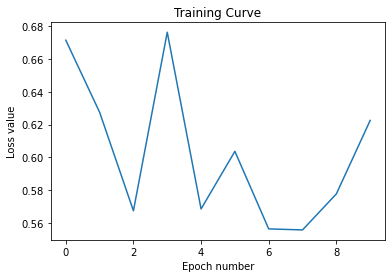

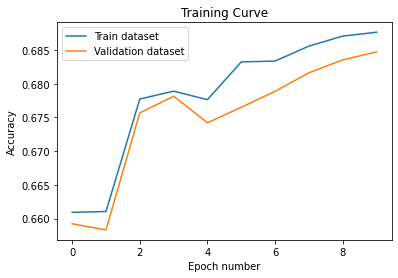

In [81]:
model = T_RNN(50, 50, 2) #postac modelu
RNN_train(model, train_loader, valid_loader, num_epochs=10, learning_rate = 2e-4)  #trenowanie modelu

In [83]:
print(get_accuracy(model, test_loader)) #dokladnosc na zbiorze testowym

0.68337899543379


<h4> Zadanie3: zadanie z pdf.

<h3> LSTM

In [64]:
#podobna skladnia jak dla RNN

lstm_layer = nn.LSTM(input_size=50,   #wymiar wejscia
                    hidden_size=5,   #wymiar cech w stanie ukrytym
                    batch_first=True) 

In [66]:
h0 = torch.zeros(1, 1, 5)     #początkowy stan ukryty
c0 = torch.zeros(1, 1, 5)     #początkowy cell state
out, last_hidden = lstm_layer(tweet_input, (h0, c0)) #drugi argument sklada sie z h0 i c0 [RNN mialo tylko h0]
out.shape

torch.Size([1, 20, 5])

In [67]:
class T_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors) #embeddingi
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) #LSTM
        self.fc = nn.Linear(hidden_size, num_classes)  #przeksztalcenie liniowe
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy  h0
        c0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy c0
        out, _ = self.lstm(x, (h0, c0))  #LSTM
        out = self.fc(out[:, -1, :]) #przeksztlcam jeszcze liniowo ostatni output
        return out

Epoch number: 1 | Loss value: 0.5998748540878296 | Train accuracy: 0.658 | Valid accuracy: 0.651
Epoch number: 2 | Loss value: 0.6958214044570923 | Train accuracy: 0.677 | Valid accuracy: 0.67
Epoch number: 3 | Loss value: 0.5215671062469482 | Train accuracy: 0.686 | Valid accuracy: 0.68
Epoch number: 4 | Loss value: 0.60875004529953 | Train accuracy: 0.694 | Valid accuracy: 0.688
Epoch number: 5 | Loss value: 0.5585095882415771 | Train accuracy: 0.697 | Valid accuracy: 0.688
Epoch number: 6 | Loss value: 0.543899655342102 | Train accuracy: 0.705 | Valid accuracy: 0.695
Epoch number: 7 | Loss value: 0.5191479921340942 | Train accuracy: 0.704 | Valid accuracy: 0.698
Epoch number: 8 | Loss value: 0.5657405257225037 | Train accuracy: 0.709 | Valid accuracy: 0.698
Epoch number: 9 | Loss value: 0.5346114635467529 | Train accuracy: 0.712 | Valid accuracy: 0.709
Epoch number: 10 | Loss value: 0.5416251420974731 | Train accuracy: 0.711 | Valid accuracy: 0.709


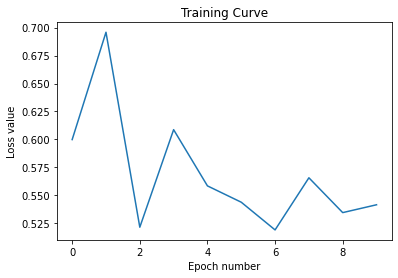

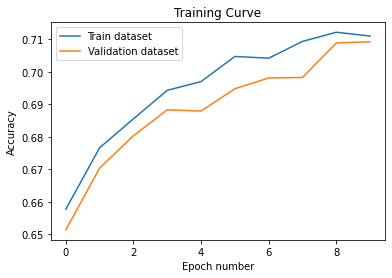

In [69]:
model_lstm = T_LSTM(50, 50, 2) #model
RNN_train(model_lstm, train_loader, valid_loader, num_epochs=10, learning_rate=2e-4) #trenuje

In [70]:
print(get_accuracy(model_lstm, test_loader)) #dokladnosc na zbiorze testowym

0.699634703196347


<h4> GRU

In [71]:
gru_layer = nn.GRU(input_size=50,   #wymiar wejscia
                   hidden_size=5,   #wymiar cech w stanie ukrytym
                   batch_first=True) 

In [72]:
h0 = torch.zeros(1, 1, 5)     #początkowy stan ukryty
out, last_hidden = gru_layer(tweet_input, h0)  #tak jak w RNN, w LSTM bylo jeszcze c0
out.shape

torch.Size([1, 20, 5])

In [73]:
class T_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors) #embeddingi
        self.hidden_size = hidden_size 
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)  #GRU
        self.fc = nn.Linear(hidden_size, num_classes)   #przeksztalcenie liniowe
    
    def forward(self, x):
        x = self.emb(x)  #embeddingi
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy stan ukryty
        out, _ = self.gru(x, h0)   #GRU
        out = self.fc(out[:, -1, :]) #ostatni output przeksztalcamy liniowo jeszcze
        return out

Epoch number: 1 | Loss value: 0.627144455909729 | Train accuracy: 0.658 | Valid accuracy: 0.652
Epoch number: 2 | Loss value: 0.5452039241790771 | Train accuracy: 0.685 | Valid accuracy: 0.682
Epoch number: 3 | Loss value: 0.5791828632354736 | Train accuracy: 0.695 | Valid accuracy: 0.695
Epoch number: 4 | Loss value: 0.5830959677696228 | Train accuracy: 0.698 | Valid accuracy: 0.693
Epoch number: 5 | Loss value: 0.5432520508766174 | Train accuracy: 0.704 | Valid accuracy: 0.701
Epoch number: 6 | Loss value: 0.543517529964447 | Train accuracy: 0.711 | Valid accuracy: 0.706
Epoch number: 7 | Loss value: 0.5632123351097107 | Train accuracy: 0.712 | Valid accuracy: 0.707
Epoch number: 8 | Loss value: 0.5059976577758789 | Train accuracy: 0.717 | Valid accuracy: 0.712
Epoch number: 9 | Loss value: 0.56019127368927 | Train accuracy: 0.719 | Valid accuracy: 0.712
Epoch number: 10 | Loss value: 0.5799170732498169 | Train accuracy: 0.716 | Valid accuracy: 0.712


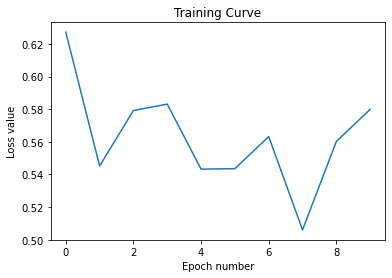

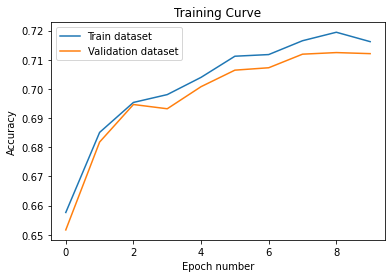

In [74]:
model_gru = T_GRU(50, 50, 2) #buduje model
RNN_train(model_gru, train_loader, valid_loader, num_epochs=10, learning_rate=2e-4) #trenuje

In [82]:
print(get_accuracy(model_gru, test_loader)) #dokladnosc na zbiorze testowym

0.7045662100456621


<h3> Wstawka

<h4> Iteratory

In [75]:
lx = [4, 7, 0, 3]
lx_iter = iter(lx)

In [76]:
print(next(lx_iter))

4


In [77]:
print(next(lx_iter))

7


In [78]:
print(next(lx_iter))

0


In [79]:
print(next(lx_iter))

3


In [80]:
print(next(lx_iter))

StopIteration: 